## Ver 4 UKF

In [59]:
!pip install filterpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110458 sha256=71a3292ec20c4b0beab8665aca8bea328c53d3a96aab45823c831896bae8921b
  Stored in directory: /root/.cache/pip/wheels/0f/0c/ea/218f266af4ad626897562199fbbcba521b8497303200186102
Successfully built filterpy


In [60]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D


In [ ]:
# Load radar data
reading_columns = ['x', 'y', 'z']
position_columns = ['x', 'y', 'z']
radar_data_path = '/content/Radar_Readings.csv'
radar_positions_path = '/content/Radar_Positions.csv'
radar_data = pd.read_csv(radar_data_path, names=reading_columns)
radar_positions = pd.read_csv(radar_positions_path, names=position_columns)

In [ ]:



def estimate_position_from_radars(radar_positions, radar_readings):
    num_radars = len(radar_positions)
    print(num_radars)
    num_timesteps = len(radar_readings) // num_radars
    estimated_positions = np.zeros((num_timesteps, 3))  # To store x, y, z for each timestep

    for i in range(num_timesteps):
        timestep_readings = radar_readings.iloc[i*num_radars:(i+1)*num_radars]

        def residuals(pos):
            dists = np.sqrt((timestep_readings['x'] - pos[0])**2 +
                            (timestep_readings['y'] - pos[1])**2 +
                            (timestep_readings['z'] - pos[2])**2)
            return dists

        initial_guess = np.mean(timestep_readings, axis=0)

        # Least squares optimization
        result = least_squares(residuals, initial_guess)
        estimated_positions[i] = result.x

    return estimated_positions



In [ ]:
positions_estimated = estimate_position_from_radars(radar_positions, radar_data)
len(positions_estimated)

In [88]:
# Constants
radius_polar = 6356752
radius_equatorial = 6378137
earth_eccentricity_squared = 6.694379e-3
M_earth = 5.972e24
G = 6.673e-11
mu = G * M_earth
dt = 1  # Time step in seconds

In [105]:
def state_transition_function(state, dt):
    # Simple motion model: x = vt + x0
    # State vector: [x, vx, y, vy, z, vz]
    x, vx, y, vy, z, vz = state
    new_x = x + vx * dt
    new_y = y + vy * dt
    new_z = z + vz * dt
    return [new_x, vx, new_y, vy, new_z, vz]
# def state_transition_function(state, dt):
#     # Unpack the state vector
#     x, vx, y, vy, z, vz = state

#     # Constants
#     mu = 3.986004418e14  # Gravitational constant * mass of the Earth (m^3/s^2)

#     # Compute the current radial distance
#     r = np.sqrt(x**2 + y**2 + z**2)

#     # Compute the acceleration due to gravity
#     acc = -mu / r**3
#     ax = acc * x
#     ay = acc * y
#     az = acc * z

#     # Update velocities
#     vx += ax * dt
#     vy += ay * dt
#     vz += az * dt

#     # Update positions
#     x += vx * dt
#     y += vy * dt
#     z += vz * dt

#     return [x, vx, y, vy, z, vz]

def measurement_function(state):
    # We only measure position, not velocity
    x, vx, y, vy, z, vz = state
    return [x, y, z]

# def run_ukf(data_test, dt):
#     points = MerweScaledSigmaPoints(6, alpha=0.1, beta=2., kappa=1.)
#     ukf = UKF(dim_x=6, dim_z=3, fx=state_transition_function, hx=measurement_function, dt=dt, points=points)
#     ukf.x = np.array([data_test.iloc[0]['x'], 0, data_test.iloc[0]['y'], 0, data_test.iloc[0]['z'], 0])  # initial state
#     ukf.R = np.diag([100, 100, 100])  # Measurement noise
#     ukf.Q = np.eye(6) * 0.01  # Process noise

#     xs, zs = [], []
#     for index, row in data_test.iterrows():
#         z = [row['x'], row['y'], row['z']]
#         ukf.predict()
#         ukf.update(z)
#         xs.append(ukf.x)
#         zs.append(z)

#     xs = np.array(xs)
#     return xs

def run_ukf(data_test, dt, num_predictions):
    points = MerweScaledSigmaPoints(6, alpha=0.1, beta=2., kappa=1.)
    ukf = UKF(dim_x=6, dim_z=3, fx=state_transition_function, hx=measurement_function, dt=dt, points=points)
    ukf.x = np.array([data_test.iloc[0]['x'], 0, data_test.iloc[0]['y'], 0, data_test.iloc[0]['z'], 0])  # initial state
    ukf.R = np.diag([10, 10, 10])  # Measurement noise
    ukf.Q = np.eye(6) * 0.01  # Process noise

    xs, zs = [], []
    # Process all available measurements
    for index, row in data_test.iterrows():
        z = [row['x'], row['y'], row['z']]
        ukf.predict()
        ukf.update(z)
        xs.append(ukf.x)
        zs.append(z)

    # Predict into the future
    for _ in range(num_predictions):
        ukf.predict()
        xs.append(ukf.x)  # only prediction, no update step

    xs = np.array(xs)
    return xs

In [106]:
data_test = pd.DataFrame(positions_estimated[:], columns=['x', 'y', 'z'])  # First 100 timesteps data

estimated_states = run_ukf(data_test, dt,0)


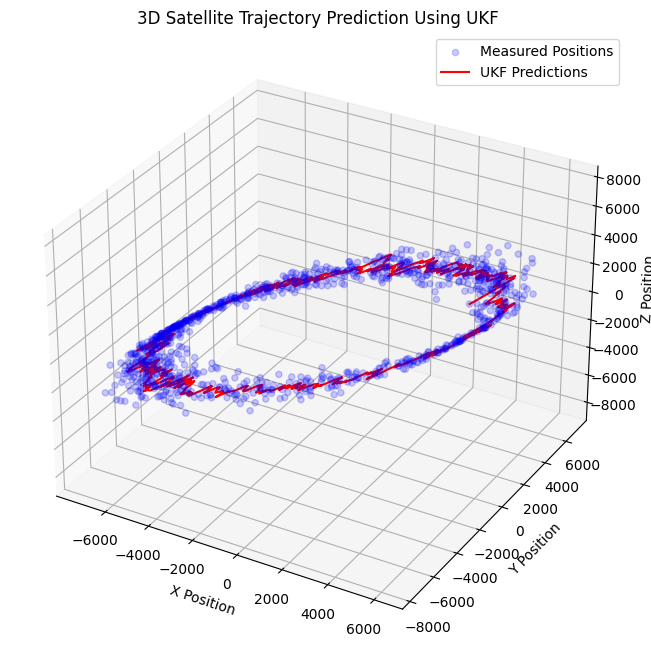

In [107]:

plt.figure(figsize=(12, 8))
ax = plt.axes(projection='3d')
ax.scatter(data_test['x'], data_test['y'], data_test['z'], c='b', label='Measured Positions',alpha=0.2)
ax.plot(estimated_states[:, 0], estimated_states[:, 2], estimated_states[:, 4], 'r-', label='UKF Predictions')
ax.set_title('3D Satellite Trajectory Prediction Using UKF')
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Z Position')
ax.legend()
plt.show()


## Ver 3

LKF

In [58]:
from scipy.optimize import least_squares
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

In [43]:

# Load radar data
reading_columns = ['x', 'y', 'z']
position_columns = ['x', 'y', 'z']
radar_data_path = '/content/Radar_Readings.csv'
radar_positions_path = '/content/Radar_Positions.csv'
radar_data = pd.read_csv(radar_data_path, names=reading_columns)
radar_positions = pd.read_csv(radar_positions_path, names=position_columns)

def estimate_position_from_radars(radar_positions, radar_readings):
    num_radars = len(radar_positions)
    print(num_radars)
    num_timesteps = len(radar_readings) // num_radars
    estimated_positions = np.zeros((num_timesteps, 3))  # To store x, y, z for each timestep

    for i in range(num_timesteps):
        timestep_readings = radar_readings.iloc[i*num_radars:(i+1)*num_radars]

        def residuals(pos):
            dists = np.sqrt((timestep_readings['x'] - pos[0])**2 +
                            (timestep_readings['y'] - pos[1])**2 +
                            (timestep_readings['z'] - pos[2])**2)
            return dists

        initial_guess = np.mean(timestep_readings, axis=0)

        # Least squares optimization
        result = least_squares(residuals, initial_guess)
        estimated_positions[i] = result.x

    return estimated_positions

positions_estimated = estimate_position_from_radars(radar_positions, radar_data)
len(positions_estimated)

8


1001

In [44]:
# Constants
radius_polar = 6356752
radius_equatorial = 6378137
earth_eccentricity_squared = 6.694379e-3
M_earth = 5.972e24
G = 6.673e-11
dt = 1  # Time step in seconds

In [45]:
def kalman_filter_3d(data_test, F, H, Q, R, P):
    num_steps = len(data_test)
    state_dimension = 6  # [x, vx, y, vy, z, vz]
    x_est = np.zeros((state_dimension, num_steps))  # State vector initialization

    # Initialize state with the first measurement and assume starting velocity is zero
    x_est[:, 0] = [data_test.iloc[0]['x'], 0, data_test.iloc[0]['y'], 0, data_test.iloc[0]['z'], 0]

    # Kalman Filter Loop
    for i in range(1, num_steps):
        # Predict
        x_pred = F @ x_est[:, i-1]
        P_pred = F @ P @ F.T + Q

        # Measurement update
        z = data_test.iloc[i][['x', 'y', 'z']].values
        y = z - H @ x_pred  # Residual
        S = H @ P_pred @ H.T + R  # Residual covariance
        K = P_pred @ H.T @ np.linalg.inv(S)  # Kalman gain
        x_est[:, i] = x_pred + K @ y
        P = (np.eye(state_dimension) - K @ H) @ P_pred

    return x_est


In [55]:
def kalman_filter_3d(data_test, F, H, Q, R, P, num_predict=0):
    num_steps = len(data_test) + num_predict
    state_dimension = 6  # [x, vx, y, vy, z, vz]
    x_est = np.zeros((state_dimension, num_steps))  # State vector initialization

    # Initialize state with the first measurement and assume starting velocity is zero
    x_est[:, 0] = [data_test.iloc[0]['x'], 0, data_test.iloc[0]['y'], 0, data_test.iloc[0]['z'], 0]

    # Kalman Filter Loop
    for i in range(1, num_steps):
        # Predict
        x_pred = F @ x_est[:, i-1]
        P_pred = F @ P @ F.T + Q

        if i < len(data_test):
            # Measurement update
            z = data_test.iloc[i][['x', 'y', 'z']].values
            y = z - H @ x_pred  # Residual
            S = H @ P_pred @ H.T + R  # Residual covariance
            K = P_pred @ H.T @ np.linalg.inv(S)  # Kalman gain
            x_est[:, i] = x_pred + K @ y
            P = (np.eye(state_dimension) - K @ H) @ P_pred
        else:
            # No measurement update for predictions
            x_est[:, i] = x_pred
            P = P_pred

    return x_est



In [56]:
data_test = pd.DataFrame(positions_estimated[:], columns=['x', 'y', 'z'])

F = np.array([
    [1, dt, 0,  0,  0,  0],
    [0,  1, 0,  0,  0,  0],
    [0,  0, 1, dt,  0,  0],
    [0,  0, 0,  1,  0,  0],
    [0,  0, 0,  0,  1, dt],
    [0,  0, 0,  0,  0,  1]
])
H = np.array([
    [1, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 1, 0]
])
R = np.diag([100, 100, 100])  # Measurement noise covariance
Q = np.diag([0.1, 0.1, 0.1, 0.1, 0.1, 0.1]) * 0.01  # Process noise covariance
P = np.diag([100, 1, 100, 1, 100, 1])  # Initial state covariance

# Run the Kalman Filter
estimated_states = kalman_filter_3d(data_test, F, H, Q, R, P)



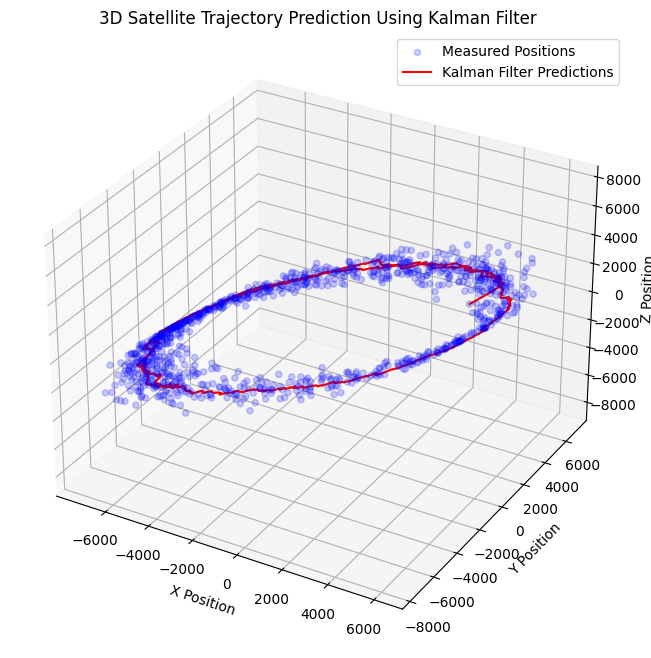

In [57]:
plt.figure(figsize=(12, 8))
ax = plt.axes(projection='3d')
ax.scatter(data_test['x'], data_test['y'], data_test['z'], c='b', label='Measured Positions', alpha=0.2)
ax.plot(estimated_states[0, :], estimated_states[2, :], estimated_states[4, :], 'r-', label='Kalman Filter Predictions')
ax.set_title('3D Satellite Trajectory Prediction Using Kalman Filter')
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Z Position')
ax.legend()
plt.show()


ver 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [4]:
# Define column names
position_columns = ['X', 'Y', 'Z']
reading_columns = ['X', 'Y', 'Z']

# Reload the data with correct column names
radar_positions = pd.read_csv('/content/Radar_Positions.csv', names=position_columns)
radar_readings = pd.read_csv('/content/Radar_Readings.csv', names=reading_columns)

# Display the data again to ensure correct loading
radar_positions.head(), radar_readings.head()

(             X            Y             Z
 0  6378.137000     0.000000  3.905483e-13
 1  1970.952725  6065.968756  3.905483e-13
 2 -5160.021225  3748.974866  3.905483e-13
 3 -5160.021225 -3748.974866  3.905483e-13
 4  1970.952725 -6065.968756  3.905483e-13,
              X            Y            Z
 0 -5076.729956  1301.407044  8679.544044
 1   353.536379 -3741.479651  9702.626105
 2  5021.320577 -3887.675514  7239.436352
 3  6467.795151  5056.748791  8685.910926
 4 -3641.488621  4395.432860  5707.601104)

In [5]:
# Constants
radius_polar = 6356.752
radius_equatorial = 6378.137
earth_eccentricity_squared = 6.694379e-3
M_earth = 5.972e24
G = 6.673e-11
dt = 1  # s

# Satellite Initial Conditions
x_initial = radar_readings.iloc[0].values  # Initial position (km)
v_initial = np.array([7800, 0, 0])  # Initial velocity (m/s)

# State Vector [x, y, z, dx, dy, dz]^T
x = np.hstack((x_initial, v_initial))

# Covariance Matrix
P = np.eye(6) * 1000

# State Transition Model
A = np.eye(6)
A[0:3, 3:6] = np.eye(3) * dt

H = np.zeros((3, 6))
H[0, 0] = 1  # X measurement directly affects X position
H[1, 1] = 1  # Y measurement directly affects Y position
H[2, 2] = 1  # Z measurement directly affects Z position


R = np.eye(3) * 500




In [6]:
def kalman_filter(x, P, Z):
    # Gravity as control input
    u = gravity(x[:3])
    B = np.zeros((6, 3))
    B[3:, :] = np.eye(3) * dt

    # Predict
    x_pred = A @ x + B @ u  # state prediction
    P_pred = A @ P @ A.T  # error covariance prediction

    # Measurement model for multiple radars
    H = np.zeros((18, 6))  # Adjusted for 6 radars measuring 3 coordinates each
    for i in range(6):
        H[3*i:3*i+3, :3] = np.eye(3)

    # Measurement noise covariance for multiple radars
    R = np.eye(18) * 500  # Adjust the noise level as per the actual measurement noise

    # Update using all radar measurements
    y = Z.flatten() - H @ x_pred  # measurement residuals for all radars
    S = H @ P_pred @ H.T + R  # residual covariance
    K = P_pred @ H.T @ np.linalg.inv(S)  # Kalman gain
    x = x_pred + K @ y  # state update
    P = (np.eye(6) - K @ H) @ P_pred  # covariance update

    return x, P


def gravity(position):
    x, y, z = position
    r = np.sqrt(x**2 + y**2 + z**2)
    gx = -G * M_earth * x / r**3
    gy = -G * M_earth * y / r**3
    gz = -G * M_earth * z / r**3
    return np.array([gx, gy, gz])
# def gravity(position):
#     x, y, z = position
#     r_eq = radius_equatorial
#     r_po = radius_polar
#     ecc = np.sqrt(1 - (r_po / r_eq)**2)
#     r = np.sqrt(x**2 + y**2 + z**2)
#     g_eq = G * M_earth / (r_eq + z)**2
#     g_po = G * M_earth / (r_po + z)**2
#     gx = -2 * G * M_earth * x * (1 + ecc * np.arctan2(y, x) / np.sqrt(x**2 + y**2)) / (r**3 * np.sqrt(x**2 + y**2))
#     gy = -2 * G * M_earth * y * (1 + ecc * np.arctan2(y, x) / np.sqrt(x**2 + y**2)) / (r**3 * np.sqrt(x**2 + y**2))
#     gz = g_eq * (1 + ecc) - g_po
#     return np.array([gx, gy, gz])

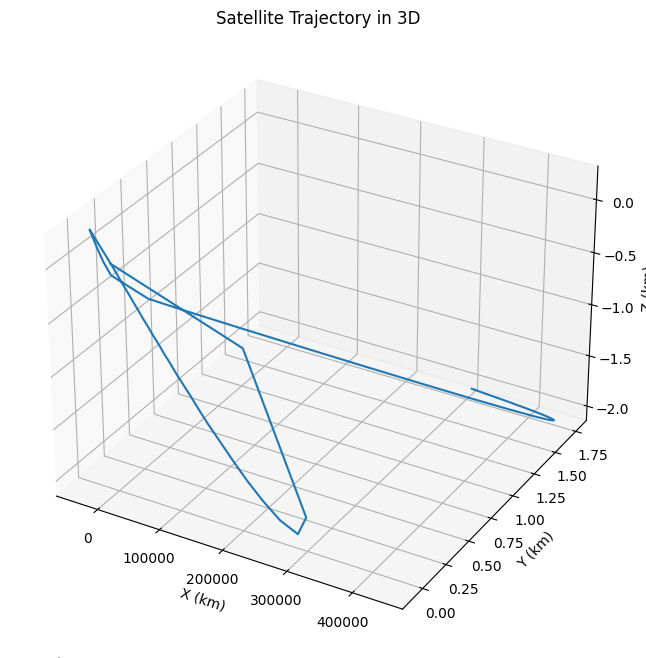

In [7]:
positions = []
times = np.arange(0, len(radar_readings) // 6, dt)

for time in times:
    start_idx = int(time * 6)
    Z = radar_readings.iloc[start_idx:start_idx+6].values  # Extract the block of measurements
    x, P = kalman_filter(x, P, Z)
    positions.append(x[:3])

positions = np.array(positions)


# Plotting the trajectory
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(positions[:, 0], positions[:, 1], positions[:, 2])
ax.set_title('Satellite Trajectory in 3D')
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_zlabel('Z (km)')
plt.show()

In [2]:


# Constants
G = 6.673e-11
M_earth = 5.972e24
dt = 1  # Time step in seconds



# Initial conditions
initial_position = radar_readings.iloc[0:6].mean().values  # Average of the first 6 rows
v_initial = np.array([7800, 0, 0])  # Initial velocity (m/s)

# State Vector [x, y, z, dx, dy, dz]^T
x = np.hstack((initial_position, v_initial))

# Covariance Matrix
P = np.eye(6) * 1000

# State Transition Model
A = np.eye(6)
A[0:3, 3:6] = np.eye(3) * dt

# Simplified gravity model
def gravity(position):
    x, y, z = position
    r = np.sqrt(x**2 + y**2 + z**2)
    gx = -G * M_earth * x / r**3
    gy = -G * M_earth * y / r**3
    gz = -G * M_earth * z / r**3
    return np.array([gx, gy, gz])

# Measurement model taking into account radar positions
def measurement_model(x, radar_positions):
    """Calculate expected measurements based on radar positions."""
    measurements = []
    for index, radar in radar_positions.iterrows():
        distance = np.linalg.norm(x[:3] - radar.values)
        measurements.append(distance)
    return np.array(measurements)

# Kalman filter function to handle measurements with radar positions
def kalman_filter(x, P, Z, radar_positions):
    # Gravity as control input
    u = gravity(x[:3])
    B = np.zeros((6, 3))
    B[3:, :] = np.eye(3) * dt

    # Predict
    x_pred = A @ x + B @ u  # state prediction
    P_pred = A @ P @ A.T  # error covariance prediction

    # Adjust H matrix based on radar geometry
    H = np.zeros((len(radar_positions)*3, 6))
    for i, _ in enumerate(radar_positions):
        H[3*i:3*i+3, :3] = np.eye(3)  # Adjust if radar measures specific components

    # Measurement noise covariance for radars
    R = np.eye(len(radar_positions)*3) * 500

    # Expected measurements from the model
    expected_measurements = measurement_model(x_pred, radar_positions)

    # Update
    y = Z.flatten() - expected_measurements  # measurement residuals
    S = H @ P_pred @ H.T + R  # residual covariance
    K = P_pred @ H.T @ np.linalg.inv(S)  # Kalman gain
    x = x_pred + K @ y  # state update
    P = (np.eye(6) - K @ H) @ P_pred  # covariance update

    return x, P

# Simulation loop
positions = []
times = np.arange(0, len(radar_readings) // 6, dt)

for time in times:
    start_idx = int(time * 6)
    Z = radar_readings.iloc[start_idx:start_idx+6].values
    x, P = kalman_filter(x, P, Z, radar_positions)
    positions.append(x[:3])

positions = np.array(positions)

# Plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(positions[:, 0], positions[:, 1], positions[:, 2])
ax.set_title('Satellite Trajectory in 3D')
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_zlabel('Z (km)')
plt.show()


NameError: name 'radar_readings' is not defined

# Ver 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir("../..")

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ES98B




Mounted at /content/drive
/content/drive/MyDrive/ES98B


In [2]:
data_path = 'data_test.csv'
data_test = pd.read_csv(data_path)
data_test.head()

,-1.649017253384058801e+00,7.378001115916245617e+06
0,699.320789,7.377999e+06
1,1400.017521,7.377999e+06
2,2099.918115,7.378002e+06
3,2799.519705,7.377997e+06
4,3498.140290,7.377999e+06


In [43]:
data_test = pd.read_csv(data_path, names=['x', 'y'])

data_test.head()

,x,y
0,-1.649017,7.378001e+06
1,699.320789,7.377999e+06
2,1400.017521,7.377999e+06
3,2099.918115,7.378002e+06
4,2799.519705,7.377997e+06


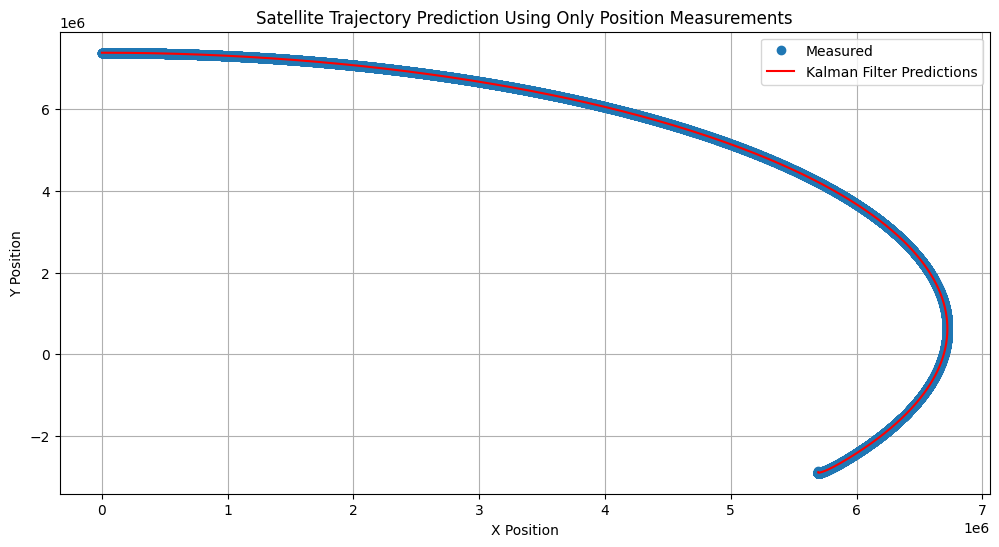

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def kalman_filter(data_test, F, H, Q, R, P, dt):
    num_steps = len(data_test)
    x_est = np.zeros((4, num_steps))  # State vector [x, vx, y, vy]

    # Initialise
    x_est[:, 0] = [data_test.iloc[0]['x'], 0, data_test.iloc[0]['y'], 0]

    # Kalman Filter implementation
    for i in range(1, num_steps):
        # Predict
        x_pred = F @ x_est[:, i-1]
        P_pred = F @ P @ F.T + Q

        # Update
        z = data_test.iloc[i][['x', 'y']].values
        y = z - H @ x_pred  # Measurement residual
        S = H @ P_pred @ H.T + R  # Residual covariance
        K = P_pred @ H.T @ np.linalg.inv(S)  # Kalman gain
        x_est[:, i] = x_pred + K @ y
        P = (np.eye(4) - K @ H) @ P_pred

    return x_est

dt = 1
F = np.array([[1, dt, 0, 0], [0, 1, 0, 0], [0, 0, 1, dt], [0, 0, 0, 1]])
H = np.array([[1, 0, 0, 0], [0, 0, 1, 0]])
R = np.diag([100, 100])
Q = np.diag([0.1, 0.1, 0.1, 0.1]) * 0.01
P = np.diag([100, 1, 100, 1])


# Run Kalman Filter
estimated_states = kalman_filter(data_test, F, H, Q, R, P, dt)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(data_test['x'], data_test['y'], 'o', label='Measured')
plt.plot(estimated_states[0, :], estimated_states[2, :], 'r-', label='Kalman Filter Predictions')
plt.title('Satellite Trajectory Prediction Using Only Position Measurements')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
def f(x, dt):
    """ Simplified motion model """
    return np.array([x[0] + dt * x[1], x[1], x[2] + dt * x[3], x[3]])

def h(x):
    """ Measurement function, only measures position """
    return np.array([x[0], x[2]])

def jacobian_f(x, dt):
    """ Jacobian of f, the state transition function """
    return np.array([[1, dt, 0, 0], [0, 1, 0, 0], [0, 0, 1, dt], [0, 0, 0, 1]])

def jacobian_h(x):
    """ Jacobian of h, the measurement function """
    return np.array([[1, 0, 0, 0], [0, 0, 1, 0]])

def extended_kalman_filter(x_est, P, z, Q, R, dt):
    # Predict
    F = jacobian_f(x_est, dt)
    x_pred = f(x_est, dt)
    P_pred = F @ P @ F.T + Q

    # Update
    H = jacobian_h(x_pred)
    z_pred = h(x_pred)
    y = z - z_pred
    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S)
    x_est = x_pred + K @ y
    P = (np.eye(4) - K @ H) @ P_pred

    return x_est, P

num_steps = len(data_test)
dt = 1.0
x_est = np.zeros((4, num_steps))
measurements = np.zeros((2, num_steps))

# Initial conditions
x_est[:, 0] = [data_test.iloc[0]['x'], 7800, data_test.iloc[0]['y'], 0]
P = np.diag([100, 10, 100, 10])
Q = np.diag([0.1, 0.1, 0.1, 0.1])
R = np.diag([25, 25])

# Generate measurements with noise
measurements[0, :] = data_test['x'] + np.random.normal(0, 100, num_steps)
measurements[1, :] = data_test['y'] + np.random.normal(0, 100, num_steps)

# Run EKF
for i in range(1, num_steps):
    x_est[:, i], P = extended_kalman_filter(x_est[:, i-1], P, measurements[:, i], Q, R, dt)



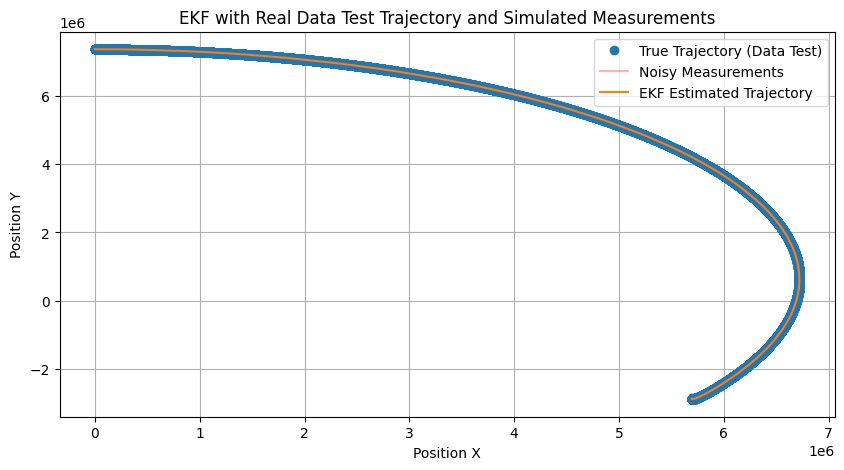

In [40]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(data_test['x'], data_test['y'], 'o', label='True Trajectory (Data Test)')
plt.plot(measurements[0, :], measurements[1, :],color='red',alpha = 0.3,label='Noisy Measurements')
plt.plot(x_est[0, :], x_est[2, :], label='EKF Estimated Trajectory')
plt.title('EKF with Real Data Test Trajectory and Simulated Measurements')
plt.xlabel('Position X')
plt.ylabel('Position Y')
plt.legend()
plt.grid(True)
plt.show()

## UKF

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load real data for position measurements
num_steps = len(data_test)

positions = np.zeros((2, num_steps))
positions[0, :] = data_test['x'] + np.random.normal(0, 100, num_steps)
positions[1, :] = data_test['y'] + np.random.normal(0, 100, num_steps)



def ukf(f, x, P, z, Q, R, dt):
    n = len(x)
    kappa = 0.1  # Smaller values for kappa can help with stability
    alpha = 1e-3  # Spread of the sigma points
    kappa = 3 - n  # Secondary scaling parameter
    beta = 2
    # Scaling factor
    lambda_ = 3 - n  # Typically kappa = 3 - n for Gaussian distributions

    # Ensure P is positive definite
    P = P + np.eye(n) * 1e-4

    # Compute square root of (lambda + n) * P
    try:
        S = np.linalg.cholesky((lambda_ + n) * P)
    except np.linalg.LinAlgError:
        # Adding a tiny value to the diagonal if P is not positive definite
        S = np.linalg.cholesky((lambda_ + n) * P + np.eye(n) * 1e-4)

    Wm = np.full(2 * n + 1, 1 / (2 * (lambda_ + n)))

    Wm[0] = lambda_ / (lambda_ + n)

    Wc = np.full(2 * n + 1, 1 / (2 * (lambda_ + n)))
    Wc[0] += 1 - alpha**2 + beta

    # Sigma points around the current mean
    sigma_points = np.column_stack([x, x[:, None] + S, x[:, None] - S]).T

    # Predict
    X_pred = np.array([f(xi, dt) for xi in sigma_points])
    print(X_pred.shape)
    x_pred = np.dot(Wm, X_pred)
    print(x_pred[:, None].shape)
    print(Wc[:, None, None].shape)
    print(X_pred - x_pred[:, None].T)
    P_pred = np.sum(Wc[:, None, None] * ((X_pred - x_pred[:, None].T) * (X_pred - x_pred[:, None].T)), axis=0)
    print(P_pred.shape)
    P_pred += Q[np.newaxis, :, :]
    # Measurement update
    Z_pred = np.array([h(xi) for xi in X_pred])
    z_pred = np.dot(Wm, Z_pred)
    Pz = R + np.sum(Wc[:, None, None] * (Z_pred - z_pred[:, None]) * (Z_pred - z_pred[:, None]), axis=0)

    try:
        Pxz = np.sum(Wc[:, None, None] * (X_pred - x_pred[:, None]) * (Z_pred - z_pred[:, None]), axis=0)
        K = np.linalg.solve(Pz.T, Pxz.T).T
    except np.linalg.LinAlgError:
        # Regularize Pz if it's not positive definite
        Pz += np.eye(*Pz.shape) * 1e-4
        K = np.linalg.solve(Pz.T, Pxz.T).T

    x = x_pred + K @ (z - z_pred)
    P = P_pred - K @ Pz @ K.T

    return x, P


# State transition function
def f(x, dt):
    return np.array([x[0] + dt * x[1], x[1], x[2] + dt * x[3], x[3]])

# Measurement function
def h(x):
    return np.array([x[0], x[2]])
# Parameters
dt = 1.0
x = np.array([data_test.iloc[0]['x'], 7800, data_test.iloc[0]['y'], 0])
P = np.diag([100, 10, 100, 10]).astype(np.float64)   # Initial uncertainty
Q = np.diag([0.1, 0.1, 0.1, 0.1])  # Process noise
R = np.array([25, 25])  # Measurement noise

# Run UKF on data
num_steps = len(positions)
trajectory = np.zeros((num_steps, 4))
for i in range(num_steps):
    x, P = ukf(f, x, P, positions[i], Q, R, dt)
    trajectory[i] = x

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(data_test['x'], data_test['y'], 'o', label='Measured Positions')
plt.plot(trajectory[:, 0], trajectory[:, 2], 'r-', label='UKF Estimated Trajectory')
plt.title('UKF Trajectory Estimation Using Real Position Data')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()


(9, 4)
(4, 1)
(9, 1, 1)
[[ 9.09494702e-13  9.09494702e-13  0.00000000e+00  0.00000000e+00]
 [ 1.73205167e+01  9.09494702e-13  0.00000000e+00  0.00000000e+00]
 [ 5.47725296e+00  5.47725296e+00  0.00000000e+00  0.00000000e+00]
 [ 9.09494702e-13  9.09494702e-13  1.73205167e+01  0.00000000e+00]
 [ 9.09494702e-13  9.09494702e-13  5.47725296e+00  5.47725296e+00]
 [-1.73205167e+01  9.09494702e-13  0.00000000e+00  0.00000000e+00]
 [-5.47725296e+00 -5.47725296e+00  0.00000000e+00  0.00000000e+00]
 [ 9.09494702e-13  9.09494702e-13 -1.73205167e+01  0.00000000e+00]
 [ 9.09494702e-13  9.09494702e-13 -5.47725296e+00 -5.47725296e+00]]
(9, 4)


ValueError: operands could not be broadcast together with shapes (9,4) (1,4,4) (9,4) 

# Ver 0

2D Scenario

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
dt = 10  # time step, s
G = 6.67430e-11  # gravitational constant, m^3 kg^-1 s^-2
M_earth = 5.972e24  # mass of the Earth, kg
R_earth = 6371000  # radius of the Earth, m

# Initial Conditions
y_initial = 500000 + R_earth  # initial altitude, m
v_initial = -7800  # initial vertical velocity, m/s


In [ ]:
## Will need further modifications

# State Vector [y, v]^T
x = np.array([y_initial, v_initial])

# Covariance Matrix
P = np.array([[1000**2, 0], [0, 100**2]])

# State Transition Model, currently assuming constant v
A = np.array([[1, dt], [0, 1]])

# Control Input (gravity only)
B = np.array([0.5 * dt**2, dt])
u = np.array([-G * M_earth / y_initial**2])

# Measurement Model
H = np.array([[1, 0]])
R = np.array([[500**2]])  # measurement noise covariance



In [73]:
# Kalman Filter Implementation
def kalman_filter(x, P):
    # Predict
    x_pred = A @ x + B * u  # state prediction, needs more modification in noise
    P_pred = A @ P @ A.T  # error covariance prediction

    if x_pred[0] <= R_earth:
        x_pred[0] = R_earth
        x_pred[1] = 0

    # Update
    z = np.random.normal(H @ x, 500)
    if z < R_earth:
        z = R_earth
    y = z - H @ x_pred
    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S)
    x = x_pred + K @ y
    P = (np.eye(len(x)) - K @ H) @ P_pred

    return x, P, x_pred[0] <= R_earth



Landing detected at time: 370s


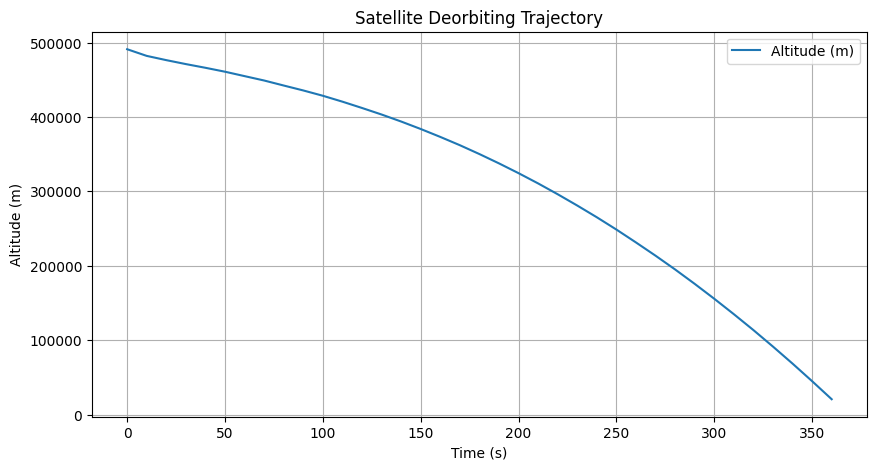

In [ ]:
altitudes = []
times = np.arange(0, 2000, dt)

# Running the Kalman Filter
for time in times:
    x, P, landed = kalman_filter(x, P)
    if landed:
        print(f"Landing detected at time: {time}s")
        break
    altitudes.append(x[0] - R_earth)

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(times[:len(altitudes)], altitudes, label='Altitude (m)')
plt.title('Satellite Deorbiting Trajectory')
plt.xlabel('Time (s)')
plt.ylabel('Altitude (m)')
plt.grid(True)
plt.legend()
plt.show()

LEO orbit:

Altitude - " It is normally at an altitude of less than 1000 km but could be as low as 160 km above Earth - which is low compared to other orbits, but still very far above Earth's surface."


Velocity - "Satellites in this orbit travel at a speed of around 7.8 km per second; at this speed, a satellite takes approximately 90 minutes to circle Earth, meaning the ISS travels around Earth about 16 times a day."

https://www.esa.int/ESA_Multimedia/Images/2020/03/Low_Earth_orbit



3D

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Constants
radius_polar = 6356752
radius_equatorial = 6378137
earth_eccentricity_squared = 6.694379e-3
M_earth = 5.972e24
G = 6.673e-11
rho_0 = 1.225
H = 8400.0 # km
A = np.pi * (3.3 / 2)**2  # m^2, satellite windward area

x_initial = np.array([-5.076729956188950382e+03,1.301407043811049789e+03,8.679544043811049050e+03])  # Initial position
v_initial = np.array([7800, 0, 0])  # Initial velocity

# State Vector [x, y, z, dx, dy, dz]^T
x = np.hstack((x_initial, v_initial))

# Covariance Matrix
P = np.eye(6) * 1000

# State Transition Model
dt = 1  # Time step
A = np.eye(6)
A[0:3, 3:6] = np.eye(3) * dt

# Measurement Model
H = np.eye(6)
R = np.eye(6) * 500

In [87]:
def gravity(position):
    x, y, z = position
    r_eq = radius_equatorial
    r_po = radius_polar
    ecc = np.sqrt(1 - (r_po / r_eq)**2)
    r = np.sqrt(x**2 + y**2 + z**2)
    g_eq = G * M_earth / (r_eq + z)**2
    g_po = G * M_earth / (r_po + z)**2
    gx = -2 * G * M_earth * x * (1 + ecc * np.arctan2(y, x) / np.sqrt(x**2 + y**2)) / (r**3 * np.sqrt(x**2 + y**2))
    gy = -2 * G * M_earth * y * (1 + ecc * np.arctan2(y, x) / np.sqrt(x**2 + y**2)) / (r**3 * np.sqrt(x**2 + y**2))
    gz = g_eq * (1 + ecc) - g_po
    return np.array([gx, gy, gz])

# Kalman filter prediction function
def kalman_filter(x, P):
    # Gravity as control input
    u = gravity(x[:3])
    B = np.zeros((6, 3))
    B[3:, :] = np.eye(3) * dt

    # Predict
    x_pred = A @ x + B @ u  # state prediction
    P_pred = A @ P @ A.T  # error covariance



    # Update
    z = H @ x + np.random.normal(0, 500, 6)  # simulate noisy measurements
    y = z - H @ x_pred  # measurement residual
    S = H @ P_pred @ H.T + R  # residual covariance
    K = P_pred @ H.T @ np.linalg.inv(S)  # Kalman gain
    x = x_pred + K @ y  # state update
    P = (np.eye(6) - K @ H) @ P_pred  # covariance update

    return x, P


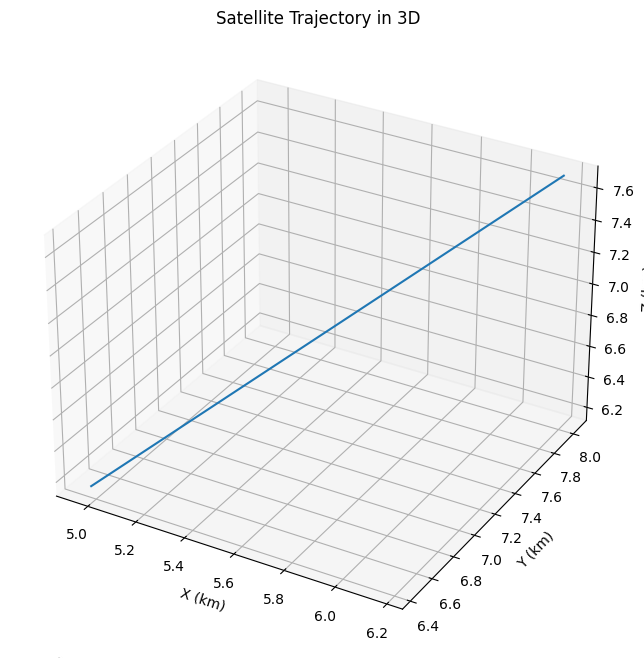

In [94]:
positions = []
times = np.arange(0, 50000, dt)

for time in times:
    x, P = kalman_filter(x, P)
    # if landed:
    #     print(f"Landing detected at time: {time}s")
    #     positions.append(x[:3])
    #     break
    positions.append(x[:3])

positions = np.array(positions)


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(positions[:, 0], positions[:, 1], positions[:, 2])
ax.set_title('Satellite Trajectory in 3D')
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_zlabel('Z (km)')
plt.show()

This bit still got some issue for simulation as there are no actual data as reference or anything therefore just standard implimentation.